# Comparing multiple groups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate some data

In this case we are gonna generate data for 5 groups, before and after treatment.

In [2]:
categories = ['treat_1', 'treat_2']

### Before treatment

In [9]:
n = 1000
mus_before_actual = np.random.randint(10, 14, len(categories))
sds_before_actual = np.random.randint(1, 4, len(categories))
X = np.random.normal(mus_before_actual, sds_before_actual, (n/len(categories), len(categories))).T.reshape(n, -1)

Create a DataFrame object

In [10]:
df_before = pd.DataFrame(data=X, columns=['Measure'])
df_before['Category'] = [el for ell in zip(*[categories] * int(n/len(categories))) for el in ell]
df_before['Category'] = df_before['Category'].astype('category')
df_before['Treatment_idx'] = 0
df_before.loc[df_before['Category'] == 'treat_2', 'Treatment_idx'] = 1
df_before['BeforeAfter'] = 'before'

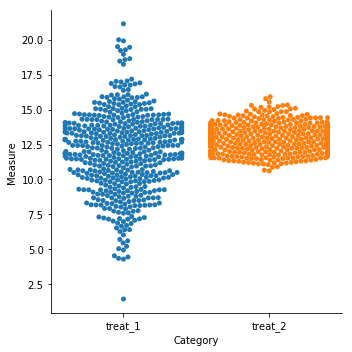

In [11]:
sns.catplot(x="Category", y="Measure", data=df_before, kind="swarm");

### After treatment

In [14]:
n = 1000
mus_after_actual = mus_before_actual - np.random.randint(3, 10, len(categories))
sds_after_actual = sds_before_actual
# sds = np.random.randint(1, 4, len(categories))

X = np.random.normal(mus_after_actual, sds_after_actual, (n/len(categories), len(categories))).T.reshape(n, -1)
df_after = pd.DataFrame(data=X, columns=['Measure'])
df_after['Category'] = [el for ell in zip(*[categories] * int(n/len(categories))) for el in ell]
df_after['Category'] = df_after['Category'].astype('category')
df_after['Treatment_idx'] = 0
df_after.loc[df_after['Category'] == 'treat_2', 'Treatment_idx'] = 1
df_after['BeforeAfter'] = 'after'

In [15]:
df = pd.concat((df_before, df_after))

Now let's make some random changes to each category

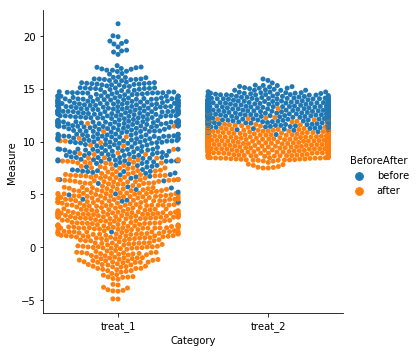

In [16]:
sns.catplot(x="Category", y="Measure", hue="BeforeAfter", kind="swarm", data=df);

---

## One treatment, one level: Paramter estimation

In [19]:
data = df.Measure[(df.Category == 'treat_1') & (df.BeforeAfter == 'before')].values

In [20]:
with pm.Model() as simple_model:
    
    # define prior for all the groups
    mu_before = pm.Normal('mu_before', mu=0, sd=2)
    sd_before = pm.HalfNormal('sd_before', sd=1)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood_before = pm.Normal('likelihood_before',mu=mu_before, sd=sd_before, observed=data)
    

In [21]:
with simple_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd_before]
>Metropolis: [mu_before]
The number of effective samples is smaller than 10% for some parameters.


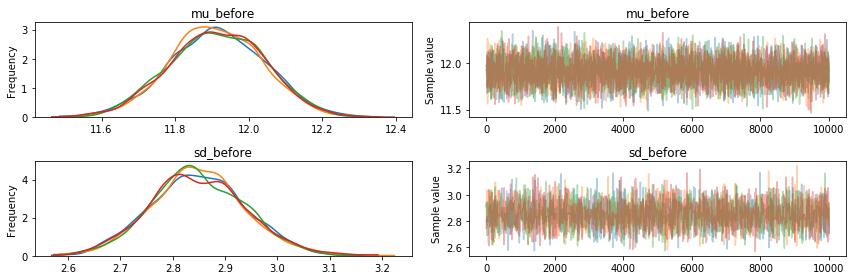

In [22]:
pm.traceplot(trace);

In [23]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_before,11.914334,0.126331,0.001647,11.661476,12.149300,5575.517590,1.000181
sd_before,2.849205,0.088954,0.001590,2.681001,3.030913,2836.413777,0.999972


In [24]:
mus_estimated = np.array(trace['mu_before'])
sds_estimated = np.array(trace['sd_before'])

In [25]:
print "Actual mu: ", mus_before_actual[0]
print "Estimated mu: ", mus_estimated.mean(axis=0)

print "Actual sd: ", sds_before_actual[0]
print "Estimated sd: ", sds_estimated.mean(axis=0)

Actual mu:  12
Estimated mu:  11.914333937821784
Actual sd:  3
Estimated sd:  2.8492045829754717


---

## Multiple treatments, two levels

In [27]:
with pm.Model() as simple_model:
    
    # define the priors for the paramters of the distribution of the samples taken before the treatment
    mu_before = pm.Normal('mu_before', mu=10, sd=2, shape=len(categories))
    sd_before = pm.HalfNormal('sd_before', sd=1, shape=len(categories))

    """
    At this point we have two mus: mu_before[0] and mu_before[1], as well as
    two sds: sd_before[0] and sd_before[1]
    
    we need a way to tell the model, which data should be considered for each mu and sd..
    How do we do that?
    
    pm.Normal either accepts a scalar value and applies it to all the data points, or an array and
    assigns it to each data point, which also means the size of the mus must be same as the datapoints 
    with proper assignment of the mu variable to the data
    
    """
    
    # since we are modeling more than one distribution, we should assign the mu variable to each datapoint
    mus_before = mu_before[df_before['Treatment_idx'].values]
    sds_before = sd_before[df_before['Treatment_idx'].values]
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood_before = pm.Normal('likelihood_before', mu=mus_before, sd=sds_before, observed=df_before.Measure.values)
    
    
    # define the priors for the paramters of the distribution of the samples taken after the treatment
    mu_after = pm.Normal('mu_after', mu=10, sd=2, shape=len(categories))
    sd_after = pm.HalfNormal('sd_after', sd=1, shape=len(categories))
    
    # create mu and sd arrays to assign the variables to every datapoint
    mus_after = mu_after[df_after['Treatment_idx'].values]
    sds_after = sd_after[df_after['Treatment_idx'].values]
    
    # likelihood function (relating the actual data to the parameters of interest)
    likelihood_after = pm.Normal('lilelihood_after', mu=mus_after, sd=sds_after, observed=df_after.Measure.values)

In [28]:
with simple_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd_after]
>Metropolis: [mu_after]
>Metropolis: [sd_before]
>Metropolis: [mu_before]
The number of effective samples is smaller than 10% for some parameters.


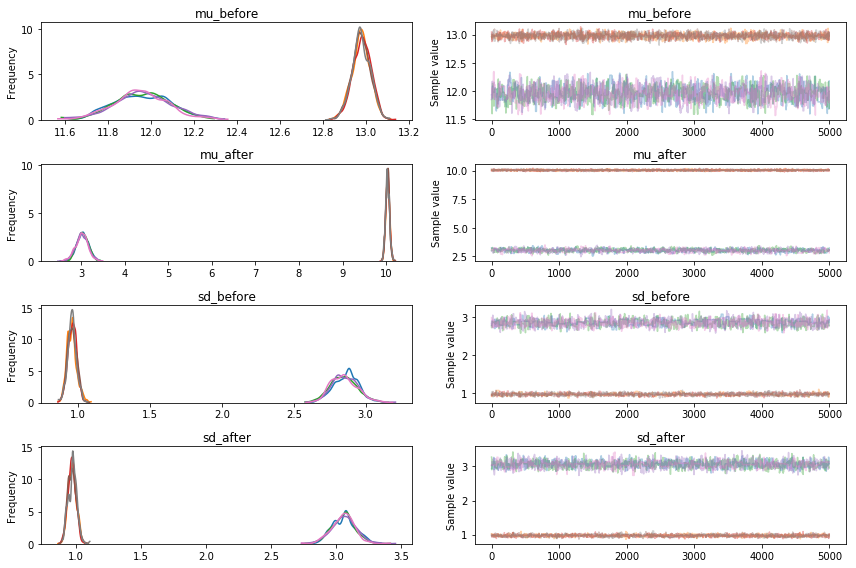

In [29]:
pm.traceplot(trace);

In [30]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_before__0,11.958674,0.131810,0.003778,11.705242,12.224596,1013.429642,1.000828
mu_before__1,12.979281,0.042526,0.000847,12.896182,13.062278,2241.755115,1.001330
mu_after__0,3.030279,0.136467,0.004600,2.779008,3.316506,934.593598,1.003524
mu_after__1,10.035233,0.043268,0.000999,9.946387,10.116228,1990.125542,1.000889
sd_before__0,2.854412,0.088667,0.002554,2.684498,3.027061,1206.259409,1.003756
sd_before__1,0.957735,0.031468,0.000841,0.899442,1.022306,1116.699759,1.001355
sd_after__0,3.061360,0.092112,0.002426,2.876399,3.234325,1370.737975,1.001385
sd_after__1,0.971374,0.031549,0.000981,0.914415,1.031388,878.463628,1.003093


In [31]:
mus_before_estimated = np.array(trace['mu_before'])
sds_before_estimated = np.array(trace['sd_before'])
mus_after_estimated = np.array(trace['mu_after'])
sds_after_estimated = np.array(trace['sd_after'])

In [32]:
print '======= Before Treatment ================'
print "Actual mus: ", mus_before_actual
print "Estimated mus: ", mus_before_estimated.mean(axis=0)

print "Actual sds: ", sds_before_actual
print "Estimated sds: ", sds_before_estimated.mean(axis=0)

print '\n======== After Treatment ================='
print "Actual mus: ", mus_after_actual
print "Estimated mus: ", mus_after_estimated.mean(axis=0)

print "Actual sds: ", sds_after_actual
print "Estimated sds: ", sds_after_estimated.mean(axis=0)

======= Before Treatment ================
Actual mus:  [12 13]
Estimated mus:  [11.9586736  12.97928129]
Actual sds:  [3 1]
Estimated sds:  [2.85441201 0.95773528]

======== After Treatment =================
Actual mus:  [ 3 10]
Estimated mus:  [ 3.03027874 10.03523311]
Actual sds:  [3 1]
Estimated sds:  [3.06136017 0.97137441]
